In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from tqdm import tqdm
from gurobipy import Model, GRB, quicksum, writeParams, setParam, read

In [2]:
relationship_mtx = pd.read_csv('../data/raw/Wedding Guest Network Data - Connection Matrix.csv', index_col=0)
constraint_mtx = pd.read_csv('../data/raw/Wedding Guest Network Data - Seating Constraints.csv', index_col=0)
guest_list_df = pd.read_csv('../data/raw/Wedding Guest Network Data - Guest List.csv', index_col=0)

In [3]:
relationship_mtx.index = ['_'.join(g.split(' ')) for g in relationship_mtx.index]
relationship_mtx.columns = ['_'.join(g.split(' ')) for g in relationship_mtx.columns]

constraint_mtx.index = ['_'.join(g.split(' ')) for g in constraint_mtx.index]
constraint_mtx.columns = ['_'.join(g.split(' ')) for g in constraint_mtx.columns]

In [4]:
constraint_mtx.fillna(0, inplace=True)

In [5]:
all(constraint_mtx.columns == relationship_mtx.columns) and all(constraint_mtx.index == relationship_mtx.index) and all(constraint_mtx.index == constraint_mtx.columns)

True

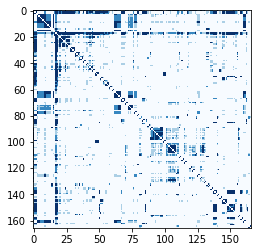

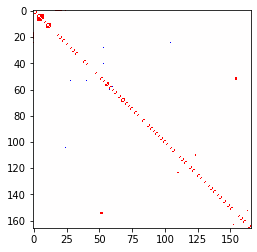

In [6]:
plt.rcParams['figure.figsize'] = (12, 12)
plt.rcParams['font.size'] = 15
plt.imshow(relationship_mtx.values, cmap='Blues', interpolation='nearest')
plt.show()

plt.imshow(constraint_mtx.values, cmap='bwr', interpolation='nearest')
plt.show()

In [7]:
guest_list = relationship_mtx.index.values.tolist()

In [8]:
len(guest_list)

166

In [9]:
for g in guest_list:
    for gp in guest_list:
        if gp == g:
            continue

        if relationship_mtx.loc[g, gp] != relationship_mtx.loc[gp, g]:
            print(f"relationship: {g} with {gp} does not match {gp} with {g}")

        if constraint_mtx.loc[g, gp] != constraint_mtx.loc[gp, g]:
            print(f"constraint: {g} with {gp} does not match {gp} with {g}")

In [10]:
guest_list_df.index = guest_list
age_difference_mtx = pd.DataFrame(0, columns=guest_list, index=guest_list)
for g in guest_list:
    for gp in guest_list:
        age_difference_mtx.loc[g, gp] = np.abs(guest_list_df.loc[g, 'age'] - guest_list_df.loc[gp, 'age'])

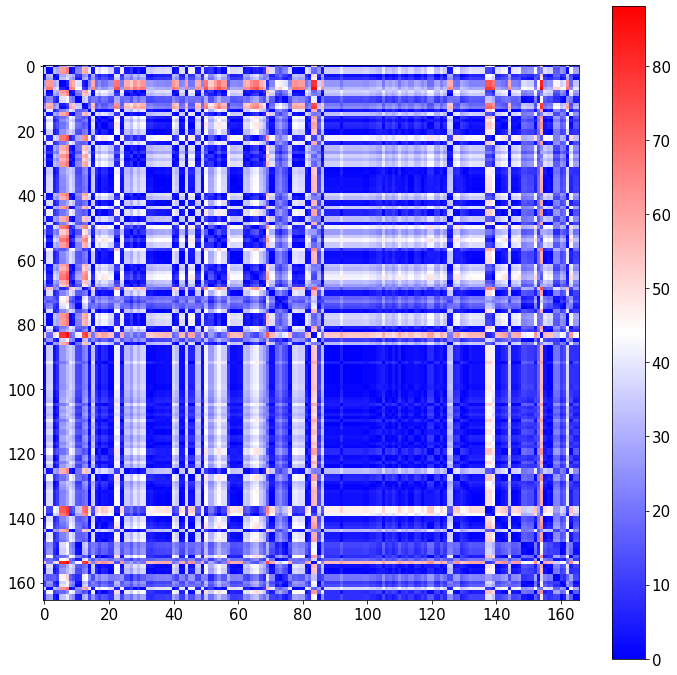

In [11]:
plt.rcParams['figure.figsize'] = (12, 12)
plt.rcParams['font.size'] = 15

plt.imshow(age_difference_mtx.values, cmap='bwr', interpolation='nearest')
plt.colorbar()
plt.show()

In [12]:
# guest_list = np.random.choice(guest_list, size=150, replace=False)

In [13]:
guests_per_table = 8
age_difference_penalty = 0.1
must_sit_together_score = 100
age_diff_zero = 6

In [14]:
n_tables = len(guest_list)//guests_per_table
extra_seats = len(guest_list) % guests_per_table
print(f'n_tables: {n_tables}, extra_seats: {extra_seats}')

n_tables: 20, extra_seats: 6


In [15]:
tables = {}
for t in range(n_tables):
    guests = guests_per_table
    guests = guests + 1 if t < extra_seats else guests
    tables[f't_{t+1}'] = guests

In [16]:
tables

{'t_1': 9,
 't_2': 9,
 't_3': 9,
 't_4': 9,
 't_5': 9,
 't_6': 9,
 't_7': 8,
 't_8': 8,
 't_9': 8,
 't_10': 8,
 't_11': 8,
 't_12': 8,
 't_13': 8,
 't_14': 8,
 't_15': 8,
 't_16': 8,
 't_17': 8,
 't_18': 8,
 't_19': 8,
 't_20': 8}

In [17]:
seating_model = Model()

Restricted license - for non-production use only - expires 2023-10-25


In [18]:
y = seating_model.addVars(guest_list, tables.keys(), vtype=GRB.BINARY, name="y")

In [19]:
objective_cost_mtx = pd.DataFrame(0, columns=guest_list, index=guest_list)
not_seated_together_list = []
must_sit_together_list = []
for i, g in enumerate(guest_list):
    for gp in guest_list[i+1:]:
        objective_cost_mtx.loc[g, gp] = age_difference_penalty * (age_difference_mtx.loc[g, gp] - age_diff_zero) if age_difference_mtx.loc[g, gp] >= age_diff_zero else 0
        objective_cost_mtx.loc[g, gp] -= relationship_mtx.loc[g, gp]
        if constraint_mtx.loc[g, gp] == 1:
            objective_cost_mtx.loc[g, gp] -= must_sit_together_score

        elif constraint_mtx.loc[g, gp] == -1:
            not_seated_together_list.append(('_'.join(g.split(' ')), '_'.join(gp.split(' '))))

In [20]:
objective_cost_mtx

,Richard_Pattison,Kathryn_Russell,Tim_Balzer,Mac_Pattison,Ali_Pattison,Ella_Pattison,Mary_Pattison,William_Pattison,Wally_Pattison,Holly_Pattison,...,Sean_Martin,Nefeli_Chondrogianni,Sean_Neel,Jenny_Falberg,Pat_Jr._Pattison,Morgan_Pattison,MC_Davault,Ryan_Hurley,Michael_Baldea,Guest_Baldea
Richard_Pattison,0,-0.2,-0.1,-3.0,-3.0,-0.9,-0.9,-0.3,-0.1,-0.5,...,-3.0,-1.0,0.3,0.3,-2.7,-1.4,3.0,-0.7,-1.9,0.1
Kathryn_Russell,0,0.0,-103.0,2.6,2.2,5.5,5.5,6.1,-2.0,-2.0,...,2.9,3.0,-2.1,-1.1,1.9,1.6,-3.0,2.7,2.1,2.1
Tim_Balzer,0,0.0,0.0,2.7,2.3,5.6,5.6,6.2,-2.0,-2.0,...,3.0,3.1,-2.0,-1.0,2.0,1.7,-3.0,2.8,2.2,2.2
Mac_Pattison,0,0.0,0.0,0.0,-103.0,-100.7,-100.7,-100.1,-0.3,-0.7,...,-1.0,0.0,1.1,1.1,-2.9,-2.6,2.8,0.5,0.0,0.0
Ali_Pattison,0,0.0,0.0,0.0,0.0,-100.3,-100.3,-99.7,-0.7,-1.1,...,0.1,0.2,0.7,0.7,-3.0,-3.0,2.4,0.9,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Morgan_Pattison,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.8,1.5,0.0,0.0
MC_Davault,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.9,2.3,2.3
Ryan_Hurley,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
Michael_Baldea,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-103.0


In [21]:
not_seated_together_list

[('Maggie_Dunn', 'James_Rogers'),
 ('Gordon_Carey', 'Robby_Mazza'),
 ('Rich_Lane', 'Robby_Mazza'),
 ('Tori_Iannuzzi', 'Mallory_Chandler')]

In [22]:
seating_model.setObjective(
    quicksum(
        quicksum(
            quicksum(
                objective_cost_mtx.loc[g, gp] * y[(g, table)] * y[(gp, table)] \
                    for table in tables.keys()) \
                for gp in guest_list[i+1:]) \
            for i, g in tqdm(enumerate(guest_list), total=len(guest_list))
    )
)

100%|██████████| 166/166 [00:13<00:00, 12.36it/s]


In [23]:
table_constraints = seating_model.addConstrs(quicksum(y[(g, table)] for g in guest_list) <= max_seats for table, max_seats in tables.items())
not_seated_together_constraints = seating_model.addConstrs(y[g, table] + y[gp, table] <= 1 for table in tables.keys() for g, gp in not_seated_together_list)
one_table_assignment_constraints = seating_model.addConstrs(quicksum(y[g, table] for table in tables.keys()) == 1 for g in guest_list)

In [24]:
len(table_constraints) + len(not_seated_together_constraints) + len(one_table_assignment_constraints)

266

In [25]:
seating_model.update()
len(seating_model.getConstrs())

266

In [26]:
sol_df = pd.read_csv('../models/solutions/seating_model_linearization2.csv')

In [45]:
sol_series = sol_df.set_index(['Person', 'Table'])['Solution']

In [47]:
for var in seating_model.getVars():
    guest, table = var.VarName.split('[')[1].split(']')[0].split(',')
    if guest in ['Alexa_Zuniga', 'Jack_Gretta']:
        continue
    var.Start = sol_series.loc[guest, table]

In [55]:
seating_model.getVars()[0].VarName

'y[Richard_Pattison,t_1]'

In [59]:
for table in tables.keys():
    var = seating_model.getVarByName(f'y[Alexa_Zuniga,{table}]')
    var.Start = 0

In [60]:
seating_model.update()

In [27]:
# seating_model.optimize()

In [25]:
solution = {t: [] for t in tables.keys()}
for var in seating_model.getVars():
    if var.X == 1.0:
        guest, table = var.VarName.split('[')[1].split(']')[0].split(',')
        solution[table].append(' '.join(guest.split('_')))

AttributeError: Unable to retrieve attribute 'X'

In [25]:
solution

{'Table_1': ['Trish Davis',
  'Wendy Bell',
  'Debbie Roper',
  'Bonnie Neel',
  'Jukka Aromaa',
  'Sean Neel',
  'Gail Olson',
  'Gordon Carey'],
 'Table_2': ['Mary Campen',
  'Rick Strauss',
  'Suzie Campen',
  'Mac Pattison',
  'Jack Gretta',
  'Morgan Pattison'],
 'Table_3': ['Claire Meunier',
  'Mallory Chandler',
  'Cameron Berkowitz',
  'Nick Baltaxe',
  'Aaron Hoogstraten',
  'Andres Cifuentes',
  'Genevieve Geoghan',
  'Hunter Sullivan'],
 'Table_4': ['Jimmy Harvey',
  'Chris Donlon',
  'Angelo Morales',
  'Danielle Harvey',
  'Megan Kesselman',
  'Natalie Kanshanchi',
  'Savannah Rivers',
  'Cody Vild']}

In [33]:
# setParam('TimeLimit', 60 * 4.5)#60 * 7.5)

Set parameter TimeLimit to value 270
Set parameter TimeLimit to value 270


In [28]:
seating_model.write('../models/seating_model_2.mps')
# writeParams('../models/seating_model_fast.prm')

In [77]:
sol_df = pd.read_csv('../models/solutions/seating_model_linearization2.csv')

In [78]:
solution = {t: [] for t in tables.keys()}
for idx, row in sol_df.iterrows():
    if row['Solution'] == 1:
        solution[row.Table].append(' '.join(row.Person.split('_')))

In [79]:
for table in solution.keys():
    if len(solution[table]) != guests_per_table + 1:
        solution[table].append('')

In [80]:
solution_mtx = pd.DataFrame(0, columns=guest_list, index=guest_list)
for g in guest_list:
    table = [t for t in tables.keys() if ' '.join(g.split('_')) in solution[t]]
    if len(table) != 1:
        print(f"{g} is in {table}")
    else:
        table = table[0]
        for gp in guest_list:
            if gp == g:
                continue
            if ' '.join(gp.split('_')) in solution[table]:
                solution_mtx.loc[g, gp] = 1

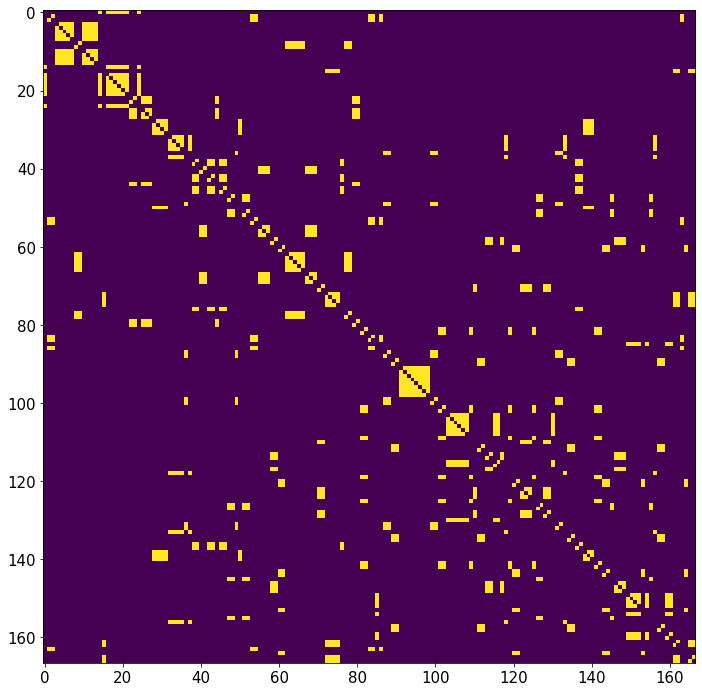

In [81]:
plt.imshow(solution_mtx.values)
plt.show()

In [82]:
solution_mtx.sum(axis=1).value_counts()

7    104
8     63
dtype: int64

In [83]:
solution_mtx.sum(axis=0).value_counts()

7    104
8     63
dtype: int64

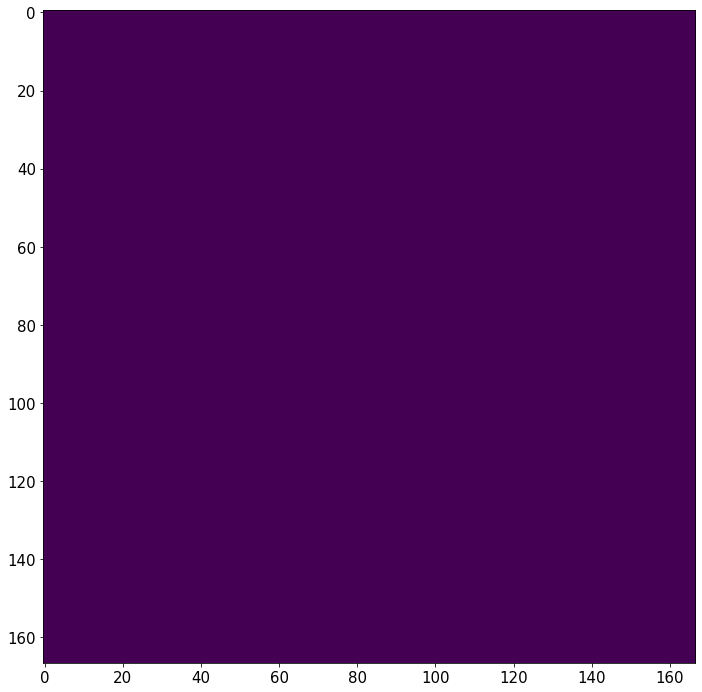

In [84]:
# violations
plt.imshow(np.maximum(0, constraint_mtx - solution_mtx))
plt.show()

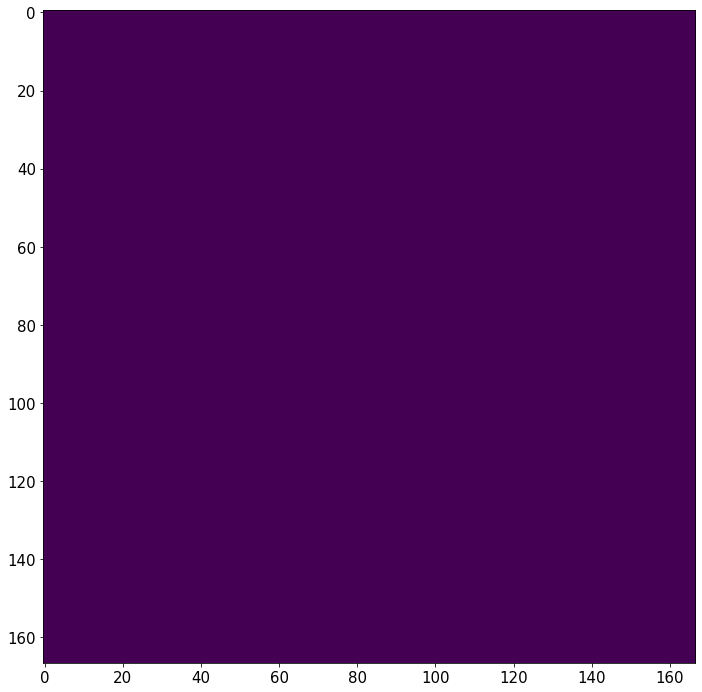

In [85]:
# violations
plt.imshow(np.minimum(0, constraint_mtx + (1 - solution_mtx)))
plt.show()

In [86]:
df_solution = pd.DataFrame(solution)
df_solution.index = [f'Guest {i+1}' for i in range(guests_per_table + 1)]

In [87]:
df_solution.to_csv('../data/transformed/seating_assignments_linearization2.csv')

In [88]:
df_solution.to_html('../../seating_assignments_linearization2.html')